In [3]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
# from modplot import *
def make_qp(nk,fname="qp.temp",nk_start=0,nk_stop=1):
    try:
        os.remove(fname)
    except:
        None
    kx=ky=np.linspace(nk_start,nk_stop,nk)
    cnt=0
    for i in kx:
        for j in ky:
            print("{:.3f} {:.3f} 0.00".format(i,j),file=open(fname, "a"))
            cnt+=1
    print("nkp = {}".format(cnt))
    
def get_s(fname='bnds.temp'):
    with open(fname) as f:
        lines = f.readlines()
    def extract_nums(text):
           return [float(i)for i in re.findall("[+-]?\d+\.\d+", text)]
    def chunks(l, n):
        n = max(1, n)
        return (l[i:i+n] for i in range(0, len(l), n))
    sx=[]
    sy=[]
    sz=[]
    e=[]
    for i in chunks(lines[1:],6):
        try:
            e.append(extract_nums(i[-5]))
            sx.append(extract_nums(i[-3]))
            sy.append(extract_nums(i[-2]))
            sz.append(extract_nums(i[-1]))
        except: None
    sx=np.array(sx)
    sy=np.array(sy)
    sz=np.array(sz)
    e=np.array(e)
    n=int(np.sqrt(sz.shape[0]))
    sx=sx.T.reshape(-1,n,n)
    sy=sy.T.reshape(-1,n,n)
    sz=sz.T.reshape(-1,n,n)
    e=e.T.reshape(-1,n,n)
    return sx,sy,sz,e


def interp(e,nk=201):
    from scipy.interpolate import interp2d
    kx2 = np.linspace(0, 1, nk)
    ky2 = np.linspace(0, 1, nk)
    f = interp2d(kx, ky, e, kind='cubic')
    e_interp = f(kx2, ky2)
    return e_interp



def get_ef(fname="bnds.temp"):
    with open(fname) as f:
        lines = f.readlines()
    return float(lines[0].split("=")[-2].split()[0])

In [4]:
nk=30
make_qp(nk,nk_start=-0.3,nk_stop=0.3)

nkp = 900


 mpirun -np 16 lmf --band\~colst\~qp\~lst=21,22,23,24\~mq ctrl.temp

In [6]:
fname="bands_data/bnds_gamma.temp"
# fname="bnds_data/bnds_full.temp"
ef=get_ef(fname)
sx,sy,sz,e=get_s(fname)
e=e-ef

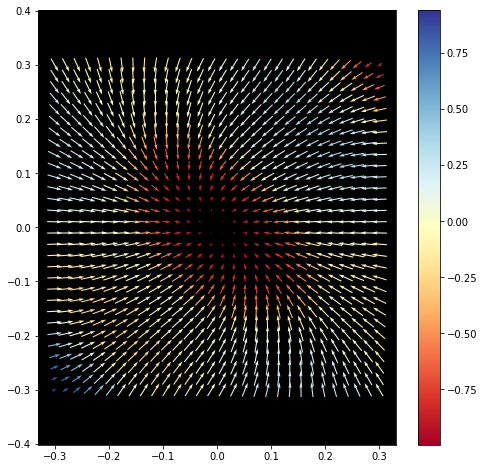

In [7]:
nk=30
kx=ky=np.linspace(-0.3,0.3,nk)
i=0
fig,ax=plt.subplots(figsize=(8,8))
ax.set_facecolor("k")
plt.axis('equal')

plt.quiver(kx, ky, sx[i], sy[i],sz[i], scale=35,width=.002, units='xy',cmap="RdYlBu",pivot="middle")
plt.colorbar()
# plt.ylim([-.05,.4])
# plt.xlim([-.05,.4])
plt.show()

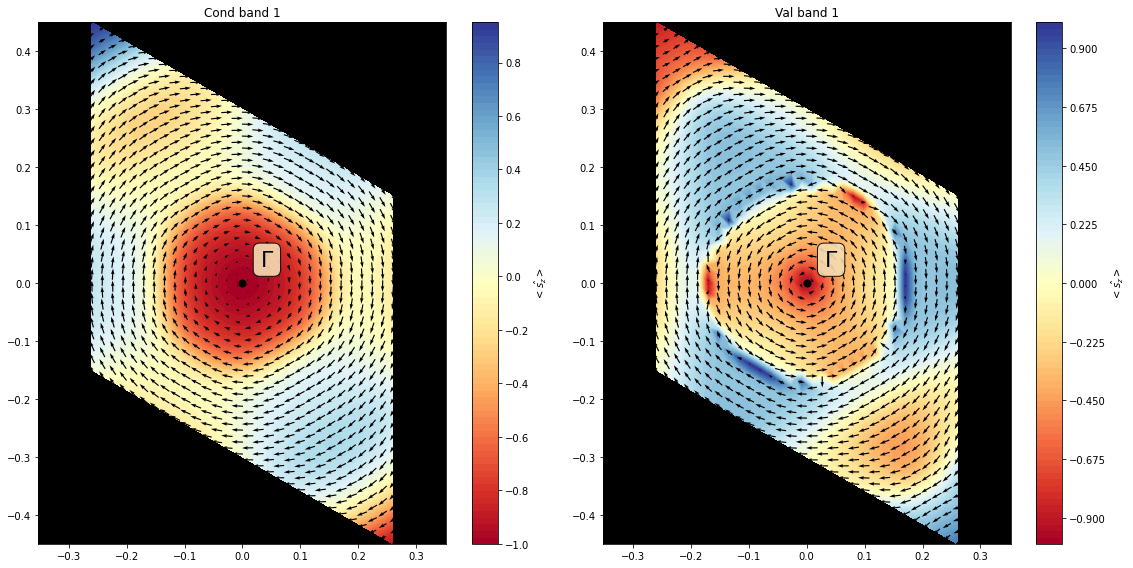

In [32]:
def plot_spins(ax,nbnd=1):
    sq3o2=np.sqrt(3.)/2.
    nk=30
    erange=[-.3,.3]
    k0=np.linspace(erange[0],erange[1],nk)
    kx=np.zeros((nk,nk),dtype=float)
    ky=np.zeros((nk,nk),dtype=float)
    for i in range(nk):
        for j in range(nk):
            kx[i,j]=sq3o2*k0[i]
            ky[i,j]=-0.5*k0[i]-k0[j]
    i=nbnd

    ax.set_facecolor("k")
    ax.axis('equal')
    # plt.quiver(kx, ky, sx[i], sy[i],sz[i], scale=8,width=.01, units='xy',cmap="RdYlBu",pivot="middle")
    ax.quiver(kx, ky, sx[i], sy[i], scale=50,width=2e-3, units='xy',color="k",pivot="middle")
    r=ax.contourf(kx,ky,sz[i],90,zorder=-1,cmap="RdYlBu")
    fig.colorbar(r, ax=ax, orientation='vertical',label="$<\hat{s_z}>$")


fig,ax1=plt.subplots(1,2,figsize=(16,8))
ax=ax1[0]
plot_spins(ax,nbnd=0)
ax.set_title("Cond band 1")
ax=ax1[1]
plot_spins(ax,nbnd=3)
ax.set_title("Val band 1")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)
for i in ax1:
    i.text(0.03,0.03,"$\\Gamma$",fontsize=22,bbox=props)
    i.scatter(0,0,s=50,c="k")
plt.tight_layout()
plt.savefig("Spin-texture.png",dpi=200)
plt.show()

In [41]:
sx.shape
np.linspace(kx.min(),kx.max(),30)
np.linspace(ky.min(),ky.max(),30)

(224,)

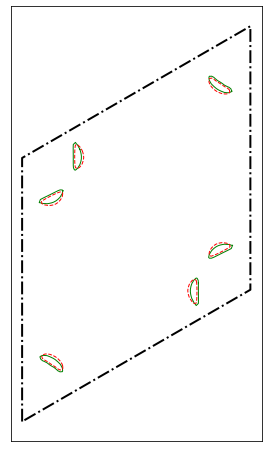

In [317]:
from skimage import measure
sq3o2=np.sqrt(3.)/2.


fig,ax=plt.subplots(figsize=(8,8))

NK=200

E=interp(e[0],nk=100)
e_cont=np.unique(np.sort(E.flatten()))[-1*NK]
contours = measure.find_contours(E, e_cont)
for n, contour in enumerate(contours):
    x=contour[:, 0]*sq3o2
    y=+0.5*contour[:, 0]*sq3o2+contour[:, 1]
    ax.plot(x,y, linewidth=1,c="green")  
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1,c="k")
    
    
E=interp(e[1],nk=100)
e_cont=np.unique(np.sort(E.flatten()))[-1*NK]
contours = measure.find_contours(E, e_cont)
for n, contour in enumerate(contours):
    x=contour[:, 0]*sq3o2
    y=+0.5*contour[:, 0]*sq3o2+contour[:, 1]
    ax.plot(x,y, linewidth=1,c="r",ls="--")    
#     ax.plot(contour[:, 1], contour[:, 0], linewidth=1,c="r")    



points=((np.array([[0,0],[0,1],[np.cos(np.pi/6),np.sin(np.pi/6)+1],[np.cos(np.pi/6),np.sin(np.pi/6)],[0,0]])-0.5)*1.04+0.5)*E.shape[0]
ax.plot(points.T[0],points.T[1]-5,c="k",lw=2,ls="-.")


ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()